## Pips

In [2]:
!pip install yellowbrick

## Libraries

In [4]:
## Core
import pandas as pd
import numpy as np
import os
import re
import time
pd.set_option('display.float_format', '{:,.2f}'.format)

In [5]:
## Preprocessing
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [6]:
## Visualization
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [7]:
## ML
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [8]:
## Quality of life
import warnings

In [9]:
%matplotlib inline
sns.set_style('whitegrid')
warnings.filterwarnings("ignore")

## Timer

In [11]:
start_time = time.time()

## Functions

In [13]:
def summarize_clusters(df, cluster_col):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.difference([cluster_col, "Customer"])
    summary = df.groupby(cluster_col)[numeric_cols].agg(['count', 'mean', 'std', 'min', 'max'])
    return summary

In [161]:
def filtered_summarize_clusters(df, cluster_col):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.difference([cluster_col, "Customer"])
    summary = df.groupby(cluster_col)[numeric_cols].agg('mean')
    counts = df.groupby(cluster_col).size()
    summary.insert(0, 'Customers', counts)
    return summary

## Paths

In [15]:
path = 'C:/Users/Chris/Desktop/ML/Clustering/Prod/Clustering/Raw_data'
pathout = 'C:/Users/Chris/Desktop/ML/Clustering/Prod/Clustering/Output'

## Preprocessing

### Load and initial dimensions

In [18]:
CustomerLineItems = pd.read_csv(path + '/CustomerLineItems.csv')

CustomerLineItems.drop('Company Code', axis = 1, inplace = True)

CustomerLineItems['Net Due Date'] = pd.to_datetime(CustomerLineItems['Net Due Date'], errors = 'coerce')
CustomerLineItems['Clearing Date'] = pd.to_datetime(CustomerLineItems['Clearing Date'], errors = 'coerce')
CustomerLineItems['Journal Entry Date'] = pd.to_datetime(CustomerLineItems['Journal Entry Date'], errors = 'coerce')

CustomerLineItems['Posting Key'] = CustomerLineItems['Posting Key'].astype('int32')

CustomerLineItems['Amount (CoCode Crcy)'] = CustomerLineItems['Amount (CoCode Crcy)'].astype('str')
CustomerLineItems['Amount (CoCode Crcy)'] = CustomerLineItems['Amount (CoCode Crcy)'].str[:-3]
CustomerLineItems['Amount (CoCode Crcy)'] = CustomerLineItems['Amount (CoCode Crcy)'].str.replace(',','')
CustomerLineItems['Amount (CoCode Crcy)'] = CustomerLineItems['Amount (CoCode Crcy)'].str.replace(' ','')
CustomerLineItems['Amount (CoCode Crcy)'] = CustomerLineItems['Amount (CoCode Crcy)'].astype(float).astype('int32')

CustomerLineItems['Outstanding'] = CustomerLineItems['Clearing Date'].isna()
# CustomerLineItems = CustomerLineItems.dropna(subset = 'Clearing Date')
CustomerLineItems['Days_to_Pay'] = (CustomerLineItems['Clearing Date'] - CustomerLineItems['Net Due Date']).dt.days

# CustomerLineItems['Late'] = CustomerLineItems['Days_to_Pay'] > 0
# CustomerLineItems['Weekday'] = CustomerLineItems['Clearing Date'].dt.day_name()
# CustomerLineItems['Day_of_Month'] = CustomerLineItems['Clearing Date'].dt.day

CustomerLineItems.drop_duplicates(inplace=True)
CustomerLineItems = CustomerLineItems.sort_values(by = 'Journal Entry Date', ascending = True).reset_index(drop = True)

print("Shape: ", CustomerLineItems.shape)
print("Duplicates: ", CustomerLineItems.duplicated().sum())
print("Null: ", CustomerLineItems.isnull().sum())
CustomerLineItems.head()

Shape:  (342785, 10)
Duplicates:  0
Null:  Customer                    0
Customer Name               0
Amount (CoCode Crcy)        0
Company Code Crcy           0
Net Due Date                0
Clearing Date           34859
Journal Entry Date          0
Posting Key                 0
Outstanding                 0
Days_to_Pay             34859
dtype: int64


,Customer,Customer Name,Amount (CoCode Crcy),Company Code Crcy,Net Due Date,Clearing Date,Journal Entry Date,Posting Key,Outstanding,Days_to_Pay
0,I8591,IMERYS Richards Bay (PTY) Ltd,13108,GBP,2022-02-25,2022-03-22,2022-01-01,1,False,25.00
1,10011170,GRUPO PUMA ESPAÑA S.L.,12733,EUR,2022-01-31,2022-02-11,2022-01-01,1,False,11.00
2,10011170,GRUPO PUMA ESPAÑA S.L.,12840,EUR,2022-01-31,2022-02-11,2022-01-01,1,False,11.00
3,10011170,GRUPO PUMA ESPAÑA S.L.,33893,EUR,2022-03-02,2022-02-11,2022-01-01,1,False,-19.00
4,10003873,ARDEX SKANDINAVIA A/S,22229,EUR,2022-01-31,2022-03-01,2022-01-01,1,False,29.00


### Feature generation

In [20]:
forex_rates = { 'GBP': 1.18,
                'USD': 0.88,
                'DKK': 0.13,
                'SEK': 0.092,
                'SGD': 0.68,
                'AUD': 0.57,
                'BGN': 0.51,
                'HUF': 0.0025,
                'MYR': 0.21,
                'THB': 0.027,
                'VND': 0.000034,
                'CAD': 0.64,
                'EGP': 0.017,
                'KRW': 0.00064,
                'NZD': 0.53,
                'MXN': 0.045,
                'EUR': 1.00,            
              }

CustomerLineItems['Amount_EUR'] = CustomerLineItems.apply(lambda row: row['Amount (CoCode Crcy)'] * forex_rates.get(row['Company Code Crcy'], 1), axis=1)
CustomerLineItems.drop(['Amount (CoCode Crcy)', 'Company Code Crcy'], axis = 1, inplace = True)

print("Shape: ", CustomerLineItems.shape)
print("Duplicates: ", CustomerLineItems.duplicated().sum())
print("Null: ", CustomerLineItems.isnull().sum())
CustomerLineItems.head()

Shape:  (342785, 9)
Duplicates:  0
Null:  Customer                  0
Customer Name             0
Net Due Date              0
Clearing Date         34859
Journal Entry Date        0
Posting Key               0
Outstanding               0
Days_to_Pay           34859
Amount_EUR                0
dtype: int64


,Customer,Customer Name,Net Due Date,Clearing Date,Journal Entry Date,Posting Key,Outstanding,Days_to_Pay,Amount_EUR
0,I8591,IMERYS Richards Bay (PTY) Ltd,2022-02-25,2022-03-22,2022-01-01,1,False,25.00,"15,467.44"
1,10011170,GRUPO PUMA ESPAÑA S.L.,2022-01-31,2022-02-11,2022-01-01,1,False,11.00,"12,733.00"
2,10011170,GRUPO PUMA ESPAÑA S.L.,2022-01-31,2022-02-11,2022-01-01,1,False,11.00,"12,840.00"
3,10011170,GRUPO PUMA ESPAÑA S.L.,2022-03-02,2022-02-11,2022-01-01,1,False,-19.00,"33,893.00"
4,10003873,ARDEX SKANDINAVIA A/S,2022-01-31,2022-03-01,2022-01-01,1,False,29.00,"22,229.00"


In [21]:
featuresDf = CustomerLineItems.groupby(['Customer','Customer Name']).agg(
    Avg_Days_to_Pay=('Days_to_Pay', 'mean'),
    #Percent_Late=('Late', lambda x: 100 * x.mean()),
    Outstanding_Amount=('Amount_EUR', lambda x: CustomerLineItems.loc[x.index, 'Outstanding'].astype(int) @ x),
    Avg_Invoice_Amount=('Amount_EUR', 'mean'),
    Total_Amount_Paid=('Amount_EUR', 'sum'),
    Invoice_Count=('Customer', 'count'),
    Max_Days_Late=('Days_to_Pay', 'max'))
   # Most_Common_Weekday=('Weekday', lambda x: {
        #'Monday': 1, 'Tuesday': 2, 'Wednesday': 3,
        #'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
        #}.get(x.mode()[0]) if not x.mode().empty else np.nan),
    #Most_Common_Day_of_Month=('Day_of_Month', lambda x: x.mode()[0] if not x.mode().empty else np.nan))

featuresDf['Invoice_Frequency_per_Month'] = featuresDf['Invoice_Count'] / 15
featuresDf['Amount_per_Month'] = featuresDf['Total_Amount_Paid'] / 15

#featuresDf['Credit_Note_Ratio'] = CustomerLineItems.groupby(['Customer','Customer Name'])['Posting Key'].apply(
                                #lambda x: (x == 11).sum() / len(x))

featuresDf.drop(['Invoice_Count', 'Total_Amount_Paid'], axis = 1 , inplace = True)
featuresDf = featuresDf.reset_index().fillna(0)
# featuresDf.insert(2,'Type', np.where(featuresDf['Customer'].str.contains('I'), 'ICO', 'Third Party'))
featuresDf = featuresDf[~featuresDf['Customer'].str.contains('^I')]
featuresDf.iloc[:, 3:] = featuresDf.iloc[:, 3:].astype('float64').round(2)

print("Shape: ", featuresDf.shape)
print("Duplicates: ", featuresDf.duplicated().sum())
print("Null: ", featuresDf.isnull().sum())
featuresDf.head()

Shape:  (9518, 8)
Duplicates:  0
Null:  Customer                       0
Customer Name                  0
Avg_Days_to_Pay                0
Outstanding_Amount             0
Avg_Invoice_Amount             0
Max_Days_Late                  0
Invoice_Frequency_per_Month    0
Amount_per_Month               0
dtype: int64


,Customer,Customer Name,Avg_Days_to_Pay,Outstanding_Amount,Avg_Invoice_Amount,Max_Days_Late,Invoice_Frequency_per_Month,Amount_per_Month
0,10000030,TERREAL Comptabilité coûts et actifs,9.13,"13,995.00","13,063.65",73.00,12.67,"165,472.96"
1,10000031,BMI GROUP OPERATION MONIER,11.13,0.00,"14,727.81",261.00,7.00,"103,094.67"
2,10000032,GEBERIT PRODUCTION,3.92,"99,515.00","8,250.00",71.00,12.80,"105,600.00"
3,10000033,CERADEL SOCOR,4.85,"260,086.40","15,822.00",100.00,15.13,"239,439.56"
4,10000034,SAS NOUVELLE PILLIVUYT,28.78,"59,725.46","14,285.24",362.00,12.20,"174,279.99"


### Final output

In [23]:
featuresDf.to_excel(pathout +'/ProcessedData.xlsx', index = False)
featuresDf.to_csv(pathout +'/ProcessedData.csv', index = False)

## ML

### Check

In [26]:
print("Shape: ", featuresDf.shape)
print("Duplicates: ", featuresDf.duplicated().sum())
print("Null: ", featuresDf.isnull().sum())
featuresDf.head()

Shape:  (9518, 8)
Duplicates:  0
Null:  Customer                       0
Customer Name                  0
Avg_Days_to_Pay                0
Outstanding_Amount             0
Avg_Invoice_Amount             0
Max_Days_Late                  0
Invoice_Frequency_per_Month    0
Amount_per_Month               0
dtype: int64


,Customer,Customer Name,Avg_Days_to_Pay,Outstanding_Amount,Avg_Invoice_Amount,Max_Days_Late,Invoice_Frequency_per_Month,Amount_per_Month
0,10000030,TERREAL Comptabilité coûts et actifs,9.13,"13,995.00","13,063.65",73.00,12.67,"165,472.96"
1,10000031,BMI GROUP OPERATION MONIER,11.13,0.00,"14,727.81",261.00,7.00,"103,094.67"
2,10000032,GEBERIT PRODUCTION,3.92,"99,515.00","8,250.00",71.00,12.80,"105,600.00"
3,10000033,CERADEL SOCOR,4.85,"260,086.40","15,822.00",100.00,15.13,"239,439.56"
4,10000034,SAS NOUVELLE PILLIVUYT,28.78,"59,725.46","14,285.24",362.00,12.20,"174,279.99"


### OHE

In [28]:
# cat_cols = ['Type']
# ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# ohe_output = ohe.fit_transform(featuresDf[cat_cols])
# encoded_col_names = ohe.get_feature_names_out(cat_cols)
# featuresDf.drop(['Type'], axis=1, inplace = True)
# featuresDf_df = pd.DataFrame(ohe_output, columns=encoded_col_names, index=featuresDf.index)
# featuresDf = pd.concat([featuresDf, featuresDf_df], axis=1)

### LE

In [30]:
# le = LabelEncoder()
# featuresDf['Type'] = le.fit_transform(featuresDf['Type'])

### Identifiers split to allow for Ml

In [32]:
identifiers = featuresDf[['Customer', 'Customer Name']].copy()
featuresDf = featuresDf.drop(identifiers, axis=1)

print("Shape: ", featuresDf.shape)
print("Duplicates: ", featuresDf.duplicated().sum())
print("Null: ", featuresDf.isnull().sum())
featuresDf.head()

Shape:  (9518, 6)
Duplicates:  124
Null:  Avg_Days_to_Pay                0
Outstanding_Amount             0
Avg_Invoice_Amount             0
Max_Days_Late                  0
Invoice_Frequency_per_Month    0
Amount_per_Month               0
dtype: int64


,Avg_Days_to_Pay,Outstanding_Amount,Avg_Invoice_Amount,Max_Days_Late,Invoice_Frequency_per_Month,Amount_per_Month
0,9.13,"13,995.00","13,063.65",73.00,12.67,"165,472.96"
1,11.13,0.00,"14,727.81",261.00,7.00,"103,094.67"
2,3.92,"99,515.00","8,250.00",71.00,12.80,"105,600.00"
3,4.85,"260,086.40","15,822.00",100.00,15.13,"239,439.56"
4,28.78,"59,725.46","14,285.24",362.00,12.20,"174,279.99"


### Outliers with Isolation Forest and drop

In [34]:
## https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
iso_forest = IsolationForest(n_jobs = -1, n_estimators=300, random_state=23)
outlier_labels = iso_forest.fit_predict(featuresDf)

outliers = featuresDf[outlier_labels == -1]
inliers = featuresDf[outlier_labels == 1]

print(f"Number of outliers detected: {len(outliers)}")
print(f"Number of inliers detected: {len(inliers)}")

Number of outliers detected: 675
Number of inliers detected: 8843


In [35]:
featuresDf['Iso_Forest'] = outlier_labels
featuresDf = pd.concat([identifiers, featuresDf], axis=1).reset_index(drop=True)

inliersDf = featuresDf[featuresDf['Iso_Forest'] == 1]
outliersDf = featuresDf[featuresDf['Iso_Forest'] == -1]

in_identifiers = inliersDf[['Customer', 'Customer Name']].copy()
inliersDf = inliersDf.drop(in_identifiers, axis=1)
inliersDf.drop('Iso_Forest', axis = 1, inplace = True)

print("Shape: ", inliersDf.shape)
print("Duplicates: ", inliersDf.duplicated().sum())
print("Null: ", inliersDf.isnull().sum())
inliersDf.head()

Shape:  (8843, 6)
Duplicates:  124
Null:  Avg_Days_to_Pay                0
Outstanding_Amount             0
Avg_Invoice_Amount             0
Max_Days_Late                  0
Invoice_Frequency_per_Month    0
Amount_per_Month               0
dtype: int64


,Avg_Days_to_Pay,Outstanding_Amount,Avg_Invoice_Amount,Max_Days_Late,Invoice_Frequency_per_Month,Amount_per_Month
0,9.13,"13,995.00","13,063.65",73.00,12.67,"165,472.96"
1,11.13,0.00,"14,727.81",261.00,7.00,"103,094.67"
2,3.92,"99,515.00","8,250.00",71.00,12.80,"105,600.00"
7,0.75,0.00,"5,248.70",61.00,1.33,"6,998.27"
8,14.47,0.00,"26,600.15",63.00,1.27,"33,693.52"


In [36]:
duplicated_inliers_df = inliersDf[inliersDf.duplicated(keep=False)].reset_index(drop = True)
duplicated_inliers_df.to_excel(pathout +'/duplicated_inliers_df.xlsx', index = False)
duplicated_inliers_df.to_csv(pathout +'/duplicated_inliers_df.csv', index = False)

print("Shape: ", duplicated_inliers_df.shape)
print("Duplicates: ", duplicated_inliers_df.duplicated().sum())
print("Null: ", duplicated_inliers_df.isnull().sum())
duplicated_inliers_df.head()

Shape:  (156, 6)
Duplicates:  124
Null:  Avg_Days_to_Pay                0
Outstanding_Amount             0
Avg_Invoice_Amount             0
Max_Days_Late                  0
Invoice_Frequency_per_Month    0
Amount_per_Month               0
dtype: int64


,Avg_Days_to_Pay,Outstanding_Amount,Avg_Invoice_Amount,Max_Days_Late,Invoice_Frequency_per_Month,Amount_per_Month
0,0.00,0.00,50.00,0.00,0.07,3.33
1,0.00,0.00,50.00,0.00,0.13,6.67
2,0.00,0.00,50.00,0.00,0.07,3.33
3,0.00,0.00,50.00,0.00,0.07,3.33
4,3.50,0.00,50.00,7.00,0.13,6.67


### Correlation heatmap

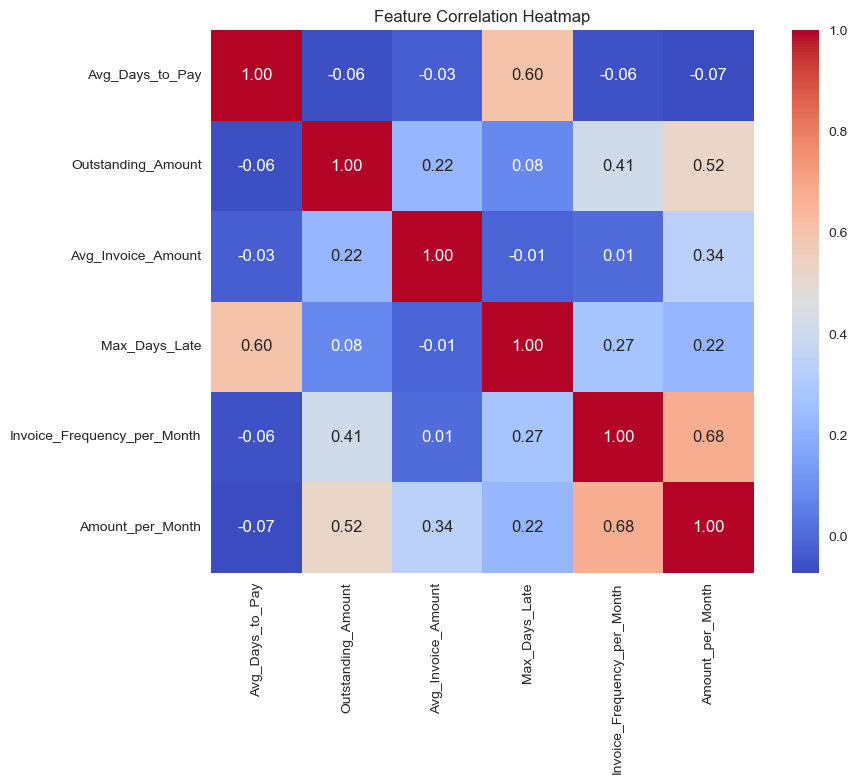

In [38]:
# Corr
corr = inliersDf.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

### Scaler

In [40]:
# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(inliersDf)
X_scaled_df = pd.DataFrame(X_scaled, columns=inliersDf.columns)

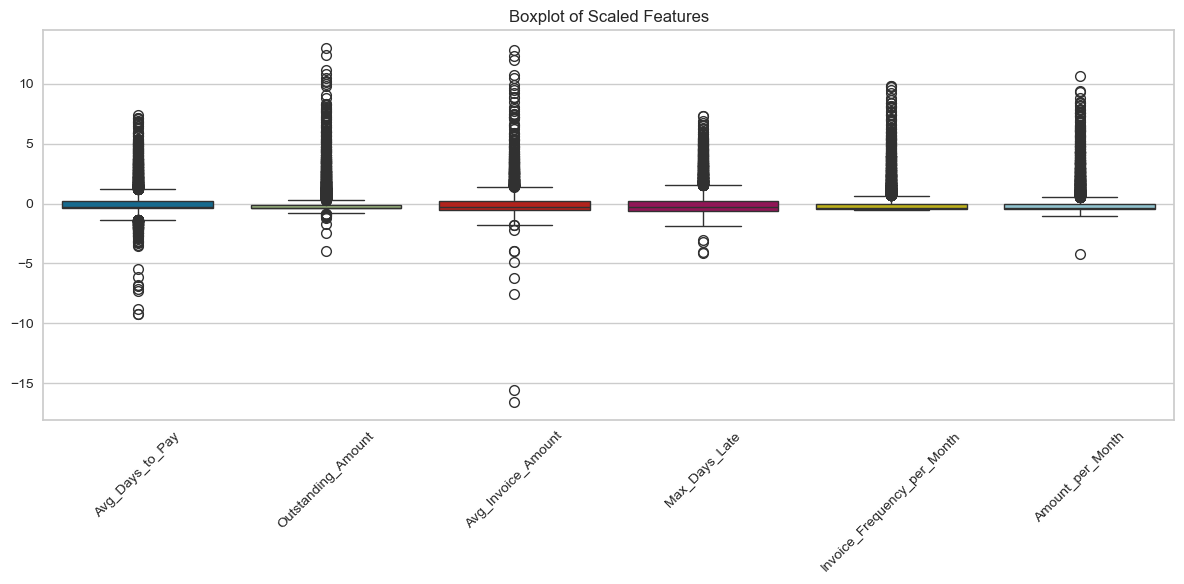

In [41]:
# Scaled plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=X_scaled_df)
plt.xticks(rotation=45)
plt.title("Boxplot of Scaled Features")
plt.tight_layout()
plt.show()

### PCA

In [43]:
pca = PCA(n_components=2)
pc_scores = pca.fit_transform(X_scaled)
pc_scores = pd.DataFrame(pc_scores, columns=["PC1", "PC2"])
explained_var = pca.explained_variance_ratio_.cumsum()
explained_var

array([0.3764861 , 0.64155074])

In [44]:
kmodel = KMeans(n_clusters=5,
                init='k-means++',
                n_init=50,
                max_iter=300,
                random_state=23)

kmodel.fit(pc_scores)
cluster_assignment = kmodel.labels_
centroids = kmodel.cluster_centers_
pc_scores["KMCluster"] = cluster_assignment
pc_scores.head()

,PC1,PC2,KMCluster
0,7.70,-0.93,3
1,5.01,1.30,3
2,6.96,-1.05,3
3,-0.23,-0.01,0
4,1.05,-0.16,2


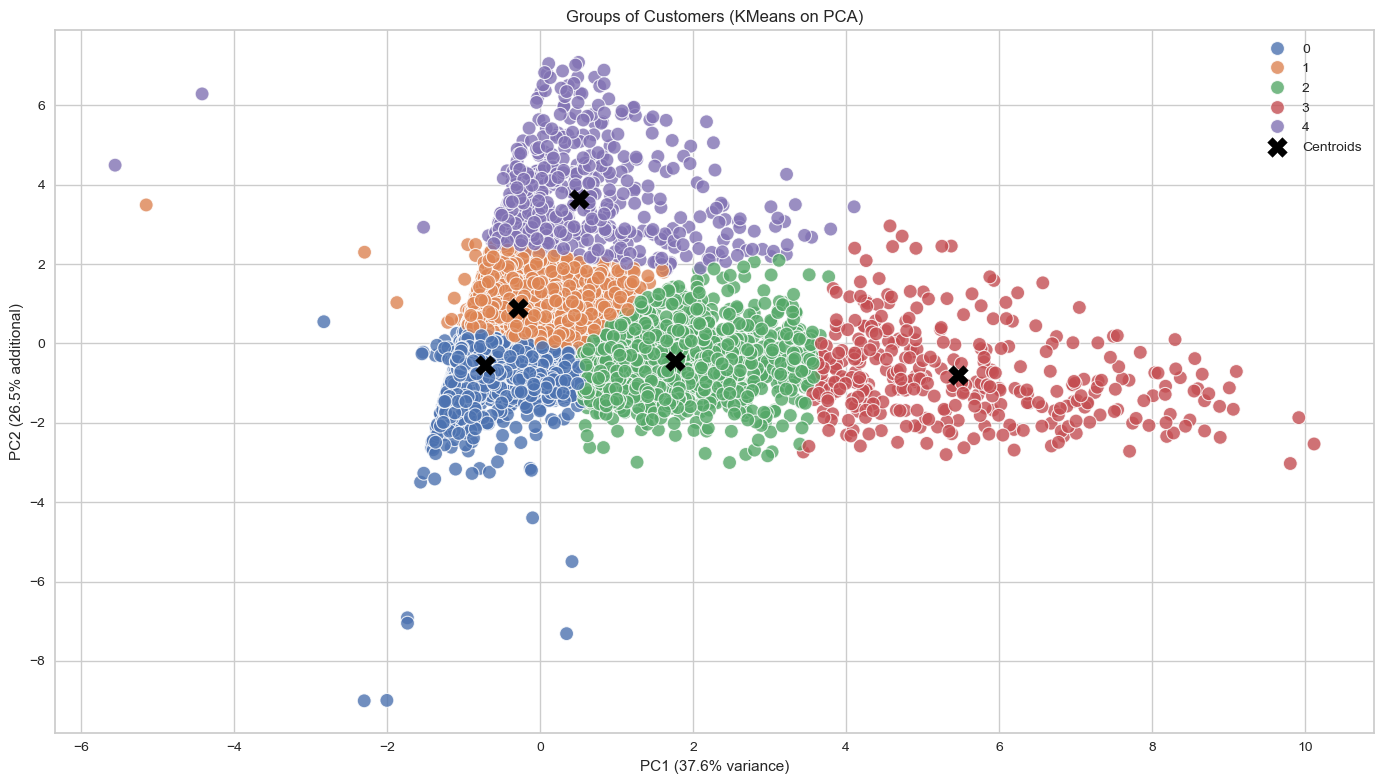

In [141]:
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=pc_scores,
    hue="KMCluster",
    palette="deep",
    s=100,
    alpha=0.8
)

# Add centroids
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    marker='X', s=200, c='black', label='Centroids'
)

# Axis titles with variance
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({(explained_var[1] - explained_var[0])*100:.1f}% additional)")
plt.title("Groups of Customers (KMeans on PCA)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Kmeans

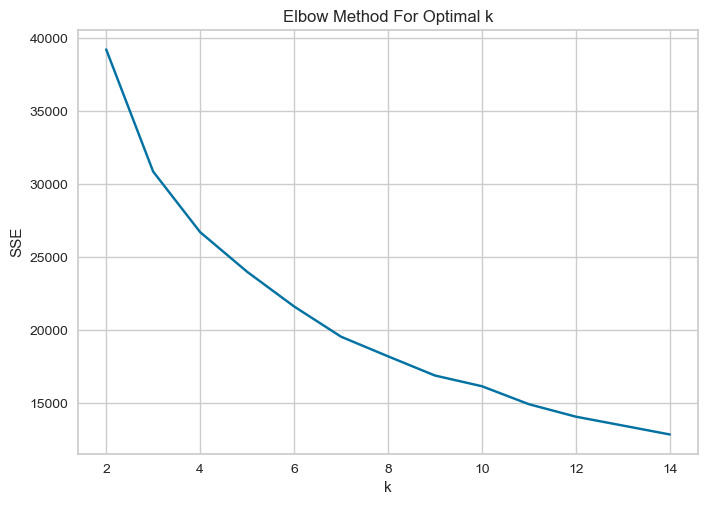

In [47]:
# Create an empty list for sum of squared distances to be appended for k values 2 to 15
Sum_of_squared_distances = [] 

# Values for K (centroids) 
K = range(2, 15)

for k in K:
    km = KMeans(n_clusters =k)
    km = km.fit(X_scaled)
    
    # model.inertia_: Sum of squared distances of samples to their closest cluster center, 
    # weighted by the sample weights if provided 
    # (from documentation - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

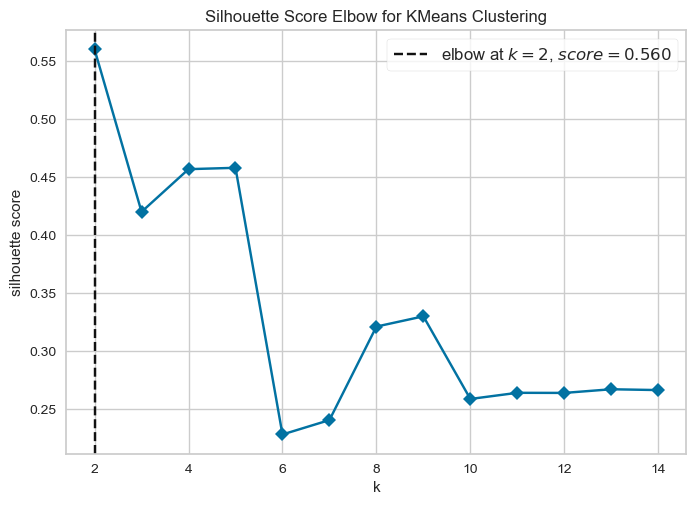

In [48]:
model = KMeans(random_state=23) 

visualizer = KElbowVisualizer(model, k=(2, 15), metric='silhouette', timings=False)
visualizer.fit(X_scaled)    
visualizer.poof()
plt.show();

In [49]:
## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
algorithms = ['lloyd', 'elkan']
K = range(2, 10)

def combined_score(silhouette, inertia, inertia_max):
    norm_inertia = 1 - (inertia / inertia_max)
    return 0.7 * silhouette + 0.3 * norm_inertia

# First pass to get maximum inertia
inertia_list = [] # Compactness
for algo in algorithms:
    for k in K:
        try:
            km = KMeans(n_clusters=k, init='k-means++', algorithm=algo, n_init=50, max_iter=300, random_state=23)
            km.fit(X_scaled)
            inertia_list.append(km.inertia_)
        except:
            continue
max_inertia = max(inertia_list)

# Full pass with combined scoring
Kmeans_optimization = []
for algo in algorithms:
    for k in K:
        try:
            km = KMeans(n_clusters=k, init='k-means++', algorithm=algo, n_init=50, max_iter=300, random_state=23)
            labels = km.fit_predict(X_scaled)
            inertia = km.inertia_
            silhouette = silhouette_score(X_scaled, labels) ## Separation and Cohesion
            combo = combined_score(silhouette, inertia, max_inertia)
            Kmeans_optimization.append({ 'n_clusters': k, 'algorithm': algo, 'inertia': inertia,
                                        'silhouette_score': silhouette, 'combined_score': combo})
            
        except Exception as e:
            print(f"Skipped: k={k}, algorithm={algo}, reason={e}")

Kmeans_optimization_df = pd.DataFrame(Kmeans_optimization)
opt_Kmeans = Kmeans_optimization_df.loc[Kmeans_optimization_df['combined_score'].idxmax()]
print(opt_Kmeans)

n_clusters                 5
algorithm              lloyd
inertia            24,014.23
silhouette_score        0.46
combined_score          0.44
Name: 3, dtype: object


In [50]:
# Manual checkpoint of Kmeans
# n_clusters                     5
# algorithm                  lloyd
# inertia                26,732.02
# silhouette_score            0.46
# combined_score              0.44

In [51]:
opt_kmeans_k = int(opt_Kmeans['n_clusters'])
opt_kmeans_algo = opt_Kmeans['algorithm']

kmodel = KMeans(n_clusters=opt_kmeans_k,
                init='k-means++',
                algorithm=opt_kmeans_algo,
                n_init=50,
                max_iter=300,
                random_state=23)

inliersDf["KMCluster"] = kmodel.fit_predict(X_scaled)
print(inliersDf['KMCluster'].value_counts())

KMCluster
0    6319
1    1123
3     561
2     546
4     294
Name: count, dtype: int64


### HCA

In [53]:
## No meaningful results in dataset
# ## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
# linkage_list = ['ward', 'complete', 'average', 'single']
# metric_list = ['euclidean', 'manhattan', 'cosine']
# cluster_range = range(2, 20)

# HCA_optimization = []
# for linkage in linkage_list:
#     for metric in metric_list:
#         if linkage == 'ward' and metric != 'euclidean':
#             continue  # incompatible
#         for n_clusters in cluster_range:
#             try:
#                 model = AgglomerativeClustering(
#                         n_clusters=n_clusters,
#                         linkage=linkage,
#                         metric=metric)
#                 labels = model.fit_predict(X_scaled)
#                 score = silhouette_score(X_scaled, labels)
#                 HCA_optimization.append({'linkage': linkage,
#                                         'metric': metric,
#                                         'n_clusters': n_clusters,
#                                         'silhouette_score': score})
#             except Exception as e:
#                 print(f"Skipped: linkage={linkage}, metric={metric}, n_clusters={n_clusters}, reason={e}")

# HCA_optimization_df = pd.DataFrame(HCA_optimization)
# opt_HCA = HCA_optimization_df.loc[HCA_optimization_df['silhouette_score'].idxmax()]

# print(opt_HCA)

In [54]:
# Manual checkpoint of HCA
#linkage               average
#metric              euclidean
#n_clusters                  2
#silhouette_score         0.85

In [55]:
## No meaningful results in dataset
# opt_HCA_linkage = opt_HCA['linkage']
# opt_HCA_metric = opt_HCA['metric']
# opt_HCA_k = int(opt_HCA['n_clusters'])

# agglomerative = AgglomerativeClustering(n_clusters=opt_HCA_k, linkage=opt_HCA_linkage, metric=opt_HCA_metric)

# agglomerative.fit_predict(X_scaled)
# cluster_assignment = agglomerative.labels_
# inliersDf["HCACluster"] = cluster_assignment

# print(inliersDf['HCACluster'].value_counts())

### DBSCAN

In [57]:
## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
# eps  = np.linspace(0.3, 2.0, 20)
# mins = np.arange(5, 101, 5)
# Z = np.zeros((len(eps), len(mins)))

# for i, e in enumerate(eps):
#     for j, m in enumerate(mins):
#         db = DBSCAN(eps=e, min_samples=m)
#         labels = db.fit_predict(X_scaled)
#         n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#         Z[i, j] = n_clusters

In [58]:
# plt.figure(figsize=(12, 8))
# sns.heatmap(Z, cmap='RdBu', center=0, annot=True)
# plt.xticks(np.arange(Z.shape[1]), mins)
# plt.xlabel('min_samples')
# plt.yticks(np.arange(Z.shape[0]), [f"{x:.2f}" for x in eps])
# plt.ylabel('eps')
# plt.title("DBSCAN Cluster Count Heatmap")
# plt.tight_layout()
# plt.show()

In [59]:
## No meaningful results in dataset
# results = []
# best_config = None

# metrics = ['euclidean', 'manhattan', 'cosine']
# eps_values = np.arange(0.1, 3.0, 0.2)
# min_samples_values = range(5, 101, 5)

# for metric in metrics:
#     for eps in eps_values:
#         for min_samples in min_samples_values:
#             try:
#                 db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
#                 labels = db.fit_predict(X_scaled)
#                 n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#                 n_noise = list(labels).count(-1)
#                 if n_clusters <= 1:
#                     continue
#                 score = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
#                 result = {
#                     'eps': eps,
#                     'min_samples': min_samples,
#                     'metric': metric,
#                     'clusters': n_clusters,
#                     'noise_points': n_noise,
#                     'silhouette': score
#                 }
#                 results.append(result)
#                 if best_config is None or score > best_config['silhouette']:
#                     best_config = result
#             except Exception as e:
#                 print(f"Skipped: eps={eps}, min_samples={min_samples}, metric={metric}, reason={e}")
#                 continue

# results_df = pd.DataFrame(results)
# if not results_df.empty:
#     opt_DBSCAN = results_df.loc[results_df['silhouette'].idxmax()]
#     print(opt_DBSCAN)
# else:
#     print("No valid DBSCAN configuration produced more than one cluster.")

In [60]:
## Manual checkpoint of DBSCAN
# eps                  0.30
# min_samples            10
# metric          euclidean
# clusters                2
# noise_points         3202
# silhouette           0.87
# Name: 201, dtype: object

In [61]:
## No meaningful results in dataset
# best_params = {k: v for k, v in best_config.items() if k in DBSCAN().get_params()}
# dbscan_final = DBSCAN(**best_params)
# inliersDf['DBSCANCluster'] = dbscan_final.fit_predict(X_scaled)

## First output - cluster assignment

### Cluster assignment df

In [257]:
## Final df
outputdf = pd.concat([in_identifiers, inliersDf],axis = 1).reset_index(drop=True)
outputdf.rename(columns={
    'Amount_per_Month': 'Average Monthly Spend',
    'Avg_Days_to_Pay': 'Average Difference to Payment',
    'Avg_Invoice_Amount': 'Average Invoice Amount',
    'Invoice_Frequency_per_Month': 'Average Invoices per month',
    'Max_Days_Late': 'Average Maximum Days to Payment',
    'Outstanding_Amount': 'Average Outstanding Amount'
}, level=0, inplace=True)
outputdf.to_excel(pathout +'/output.xlsx', index = False)

In [259]:
print("Shape: ", outputdf.shape)
print("Duplicates: ", outputdf.duplicated().sum())
print("Null: ", outputdf.isnull().sum())
outputdf.head()

Shape:  (8843, 9)
Duplicates:  0
Null:  Customer                           0
Customer Name                      0
Average Difference to Payment      0
Average Outstanding Amount         0
Average Invoice Amount             0
Average Maximum Days to Payment    0
Average Invoices per month         0
Average Monthly Spend              0
KMCluster                          0
dtype: int64


,Customer,Customer Name,Average Difference to Payment,Average Outstanding Amount,Average Invoice Amount,Average Maximum Days to Payment,Average Invoices per month,Average Monthly Spend,KMCluster
0,10000030,TERREAL Comptabilité coûts et actifs,9.13,"13,995.00","13,063.65",73.00,12.67,"165,472.96",2
1,10000031,BMI GROUP OPERATION MONIER,11.13,0.00,"14,727.81",261.00,7.00,"103,094.67",2
2,10000032,GEBERIT PRODUCTION,3.92,"99,515.00","8,250.00",71.00,12.80,"105,600.00",2
3,10000037,CIBAS DI POLI FABIO & C. SAS,0.75,0.00,"5,248.70",61.00,1.33,"6,998.27",0
4,10000038,SOC DE PORCELANAS DE ALCOBACA SPAL,14.47,0.00,"26,600.15",63.00,1.27,"33,693.52",3


In [66]:
print(outputdf['KMCluster'].value_counts())
# print(outputdf['HCACluster'].value_counts())
# print(outputdf['DBSCANCluster'].value_counts())

KMCluster
0    6319
1    1123
3     561
2     546
4     294
Name: count, dtype: int64


### Graphs

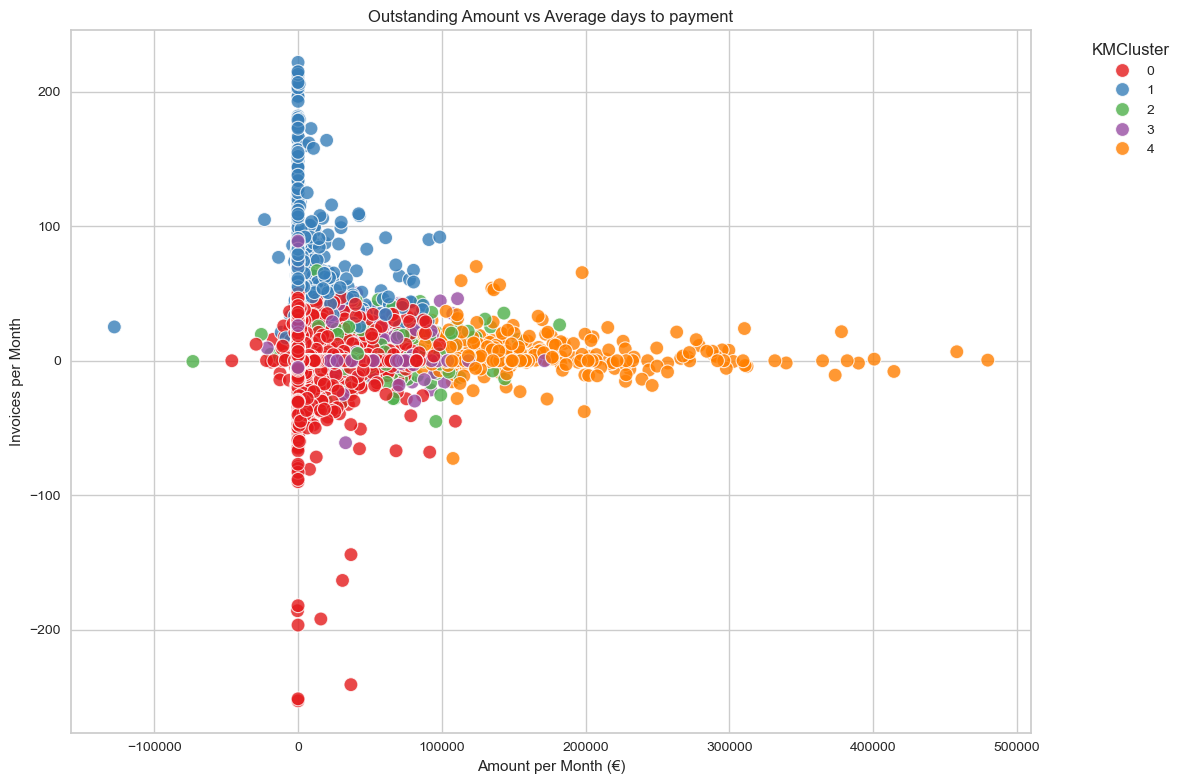

In [68]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=outputdf['Outstanding_Amount'], y=outputdf['Avg_Days_to_Pay'], hue=outputdf["KMCluster"], palette="Set1", s=100, alpha=0.8)

plt.xlabel("Amount per Month (€)")
plt.ylabel("Invoices per Month")
plt.title("Outstanding Amount vs Average days to payment")
plt.legend(title="KMCluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

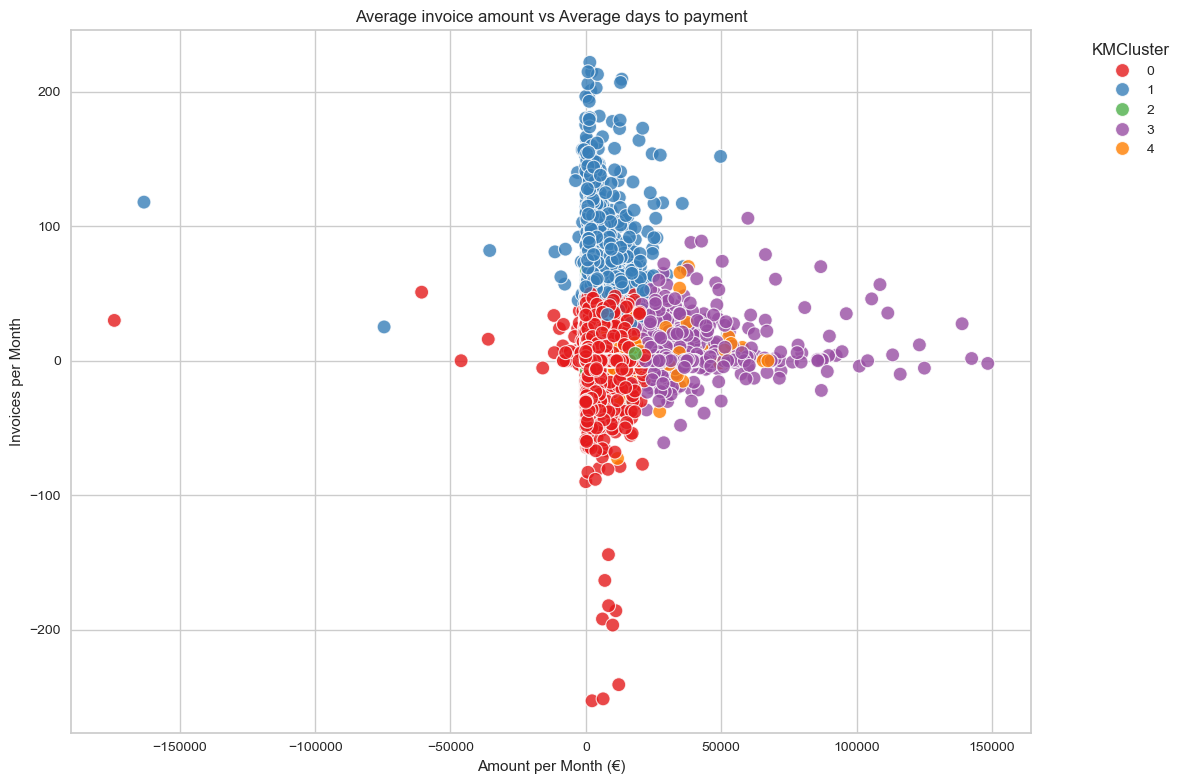

In [69]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=outputdf['Avg_Invoice_Amount'], y=outputdf['Avg_Days_to_Pay'], hue=outputdf["KMCluster"], palette="Set1", s=100, alpha=0.8)

plt.xlabel("Amount per Month (€)")
plt.ylabel("Invoices per Month")
plt.title("Average invoice amount vs Average days to payment")
plt.legend(title="KMCluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

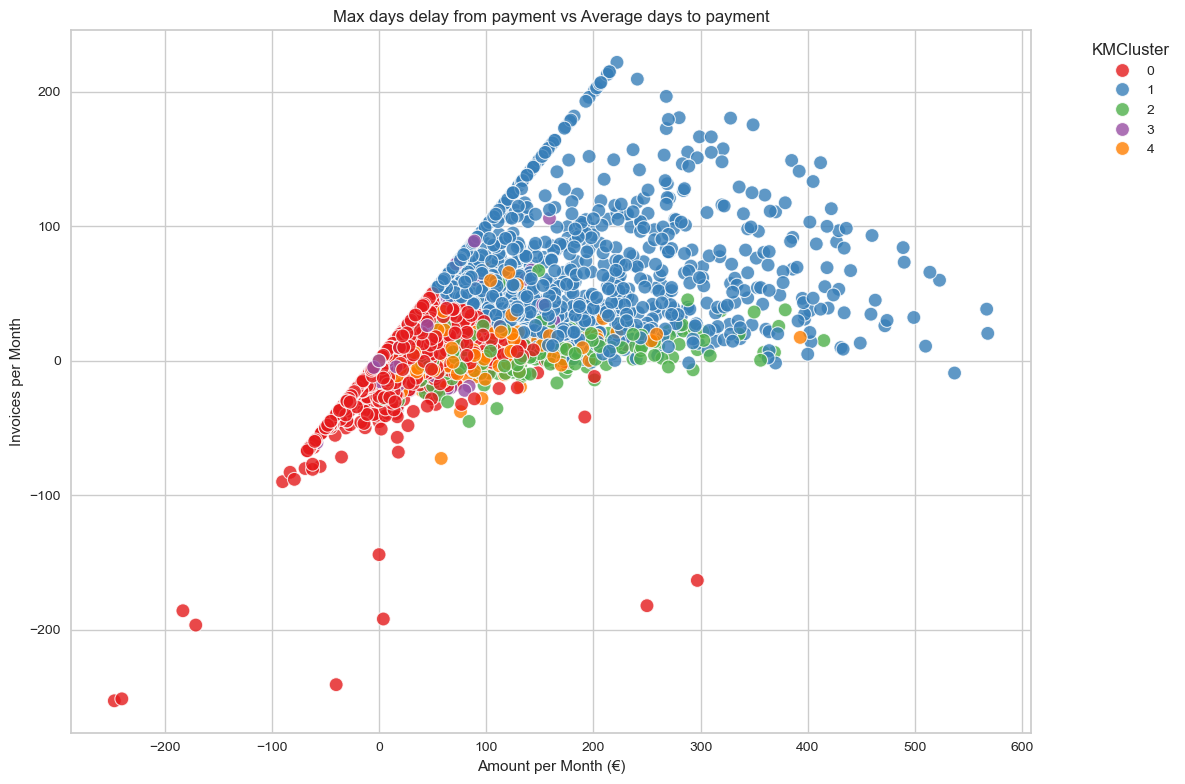

In [70]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=outputdf['Max_Days_Late'], y=outputdf['Avg_Days_to_Pay'], hue=outputdf["KMCluster"], palette="Set1", s=100, alpha=0.8)

plt.xlabel("Amount per Month (€)")
plt.ylabel("Invoices per Month")
plt.title("Max days delay from payment vs Average days to payment")
plt.legend(title="KMCluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

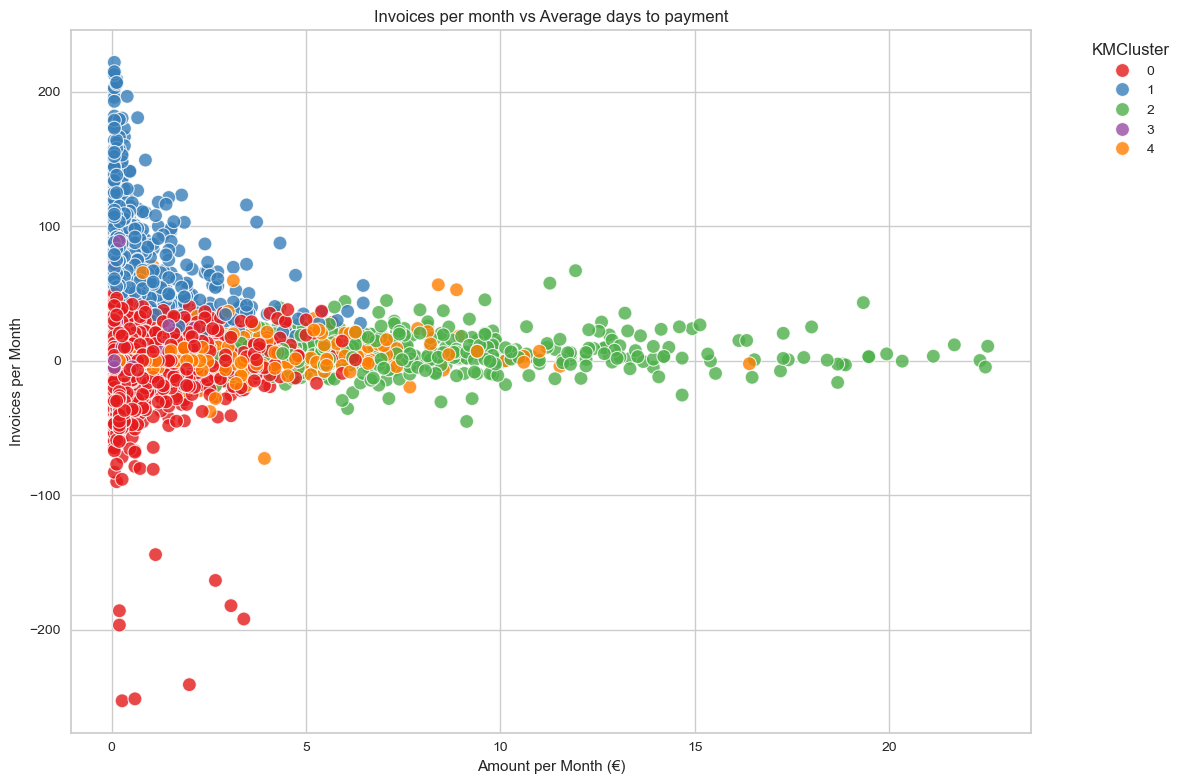

In [71]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=outputdf['Invoice_Frequency_per_Month'], y=outputdf['Avg_Days_to_Pay'], hue=outputdf["KMCluster"], palette="Set1", s=100, alpha=0.8)

plt.xlabel("Amount per Month (€)")
plt.ylabel("Invoices per Month")
plt.title("Invoices per month vs Average days to payment")
plt.legend(title="KMCluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

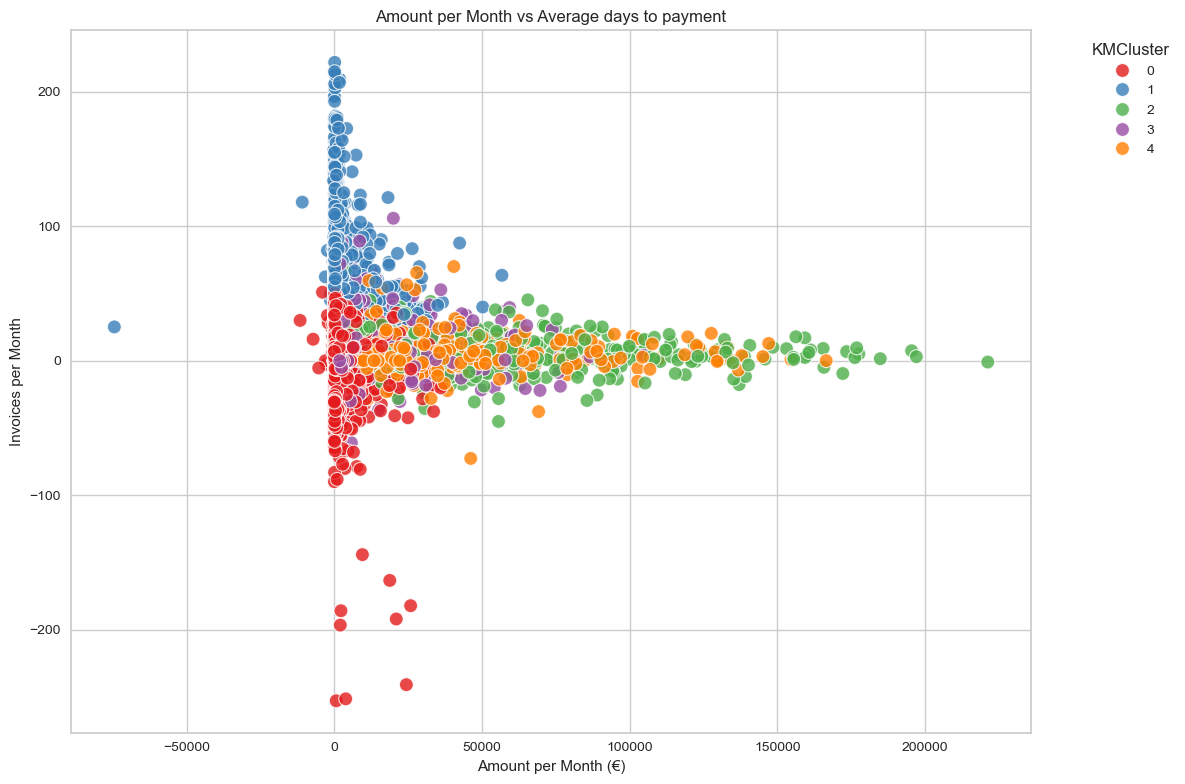

In [72]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=outputdf['Amount_per_Month'], y=outputdf['Avg_Days_to_Pay'], hue=outputdf["KMCluster"], palette="Set1", s=100, alpha=0.8)

plt.xlabel("Amount per Month (€)")
plt.ylabel("Invoices per Month")
plt.title("Amount per Month vs Average days to payment")
plt.legend(title="KMCluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Summary df

In [213]:
km_summary = summarize_clusters(outputdf, "KMCluster")
# hca_summary = summarize_clusters(outputdf, "HCACluster")
# dbscan_summary = summarize_clusters(outputdf, "DBSCANCluster")

In [261]:
km_summary.to_excel(pathout +'/km_summary.xlsx')
print(km_summary.columns.levels[0])
km_summary

Index(['Average Difference to Payment', 'Average Invoice Amount',
       'Average Invoices per month', 'Average Maximum Days to Payment',
       'Average Monthly Spend', 'Average Outstanding Amount'],
      dtype='object')


Average Monthly Spend                                            \
                          count      mean       std        min        max   
KMCluster                                                                   
0                          6319  3,466.10  5,863.64 -11,610.53  42,694.00   
1                          1123  5,153.93  8,256.83 -74,506.00  56,718.53   
2                           546 57,017.19 38,338.47   1,358.19 221,212.00   
3                           561 17,411.44 18,191.11   1,461.47 122,383.60   
4                           294 46,242.73 32,883.50   7,424.00 166,507.35   

          Average Difference to Payment                             ...  \
                                  count  mean   std     min    max  ...   
KMCluster                                                           ...   
0                                  6319  3.48 17.26 -253.00  52.00  ...   
1                                  1123 61.98 39.19   -9.15 222.00  ...   
2                                   546  6.13 12.01  -45.17  67.00  ...   
3                                   561  9.06 18.83  -61.00 106.00  ...   
4                                   294  5.56 13.85  -72.69  70.10  ...   

          Average Maximum Days to Payment                              \
                                    count   mean   std     min    max   
KMCluster                                                               
0                                    6319  20.09 31.09 -247.00 297.00   
1                                    1123 172.66 95.13   53.00 568.00   
2                                     546  98.58 73.68   -1.00 415.00   
3                                     561  28.12 34.92  -58.00 230.00   
4                                     294  62.39 58.49  -11.00 393.00   

          Average Outstanding Amount                                   \
                               count       mean       std         min   
KMCluster                                                               
0                               6319   5,628.96 12,836.08  -46,062.00   
1                               1123   6,093.79 15,168.89 -127,804.00   
2                                546  42,034.48 35,288.33  -73,147.68   
3                                561  18,830.07 28,877.54  -21,385.14   
4                                294 161,649.30 73,232.47   79,150.10   

                      
                 max  
KMCluster             
0         109,437.52  
1          98,589.44  
2         181,961.12  
3         171,433.00  
4         479,818.24  

[5 rows x 30 columns]

### Filtered Summary Df

In [219]:
# filtered_km_summary = km_summary.xs('mean', axis=1, level=1)
# filtered_km_summary.to_excel(pathout +'/filtered_km_summary.xlsx')
# filtered_km_summary

In [285]:
filtered_km_summary = filtered_summarize_clusters(outputdf, "KMCluster")
filtered_km_summary['Priority'] = [5,2,3,4,1]
filtered_km_summary = filtered_km_summary.sort_values(by='Priority')
priority_labels =  {1: "Open items",
                    2: "Chronic late payers",
                    3: "Large volume, moderate risk",
                    4: "Medium volume, moderate risk",
                    5: "Low concern"}

filtered_km_summary.insert(0, 'Description', filtered_km_summary['Priority'].map(priority_labels))
filtered_km_summary.drop('Priority', axis = 1, inplace = True)
filtered_km_summary = filtered_km_summary.reset_index(drop=False)
filtered_km_summary['Average Monthly Spend'] = filtered_km_summary['Average Monthly Spend'].astype(int)
filtered_km_summary['Average Invoice Amount'] = filtered_km_summary['Average Invoice Amount'].astype(int)
filtered_km_summary['Average Outstanding Amount'] = filtered_km_summary['Average Outstanding Amount'].astype(int)
filtered_km_summary.to_excel(pathout +'/filtered_km_summary.xlsx')
filtered_km_summary

,KMCluster,Description,Customers,Average Difference to Payment,Average Invoice Amount,Average Invoices per month,Average Maximum Days to Payment,Average Monthly Spend,Average Outstanding Amount
0,4,Open items,294,5.56,16199,3.48,62.39,46242,161649
1,1,Chronic late payers,1123,61.98,5427,0.90,172.66,5153,6093
2,2,"Large volume, moderate risk",546,6.13,9478,7.50,98.58,57017,42034
3,3,"Medium volume, moderate risk",561,9.06,35965,0.56,28.12,17411,18830
4,0,Low concern,6319,3.48,5262,0.61,20.09,3466,5628


### Graphs

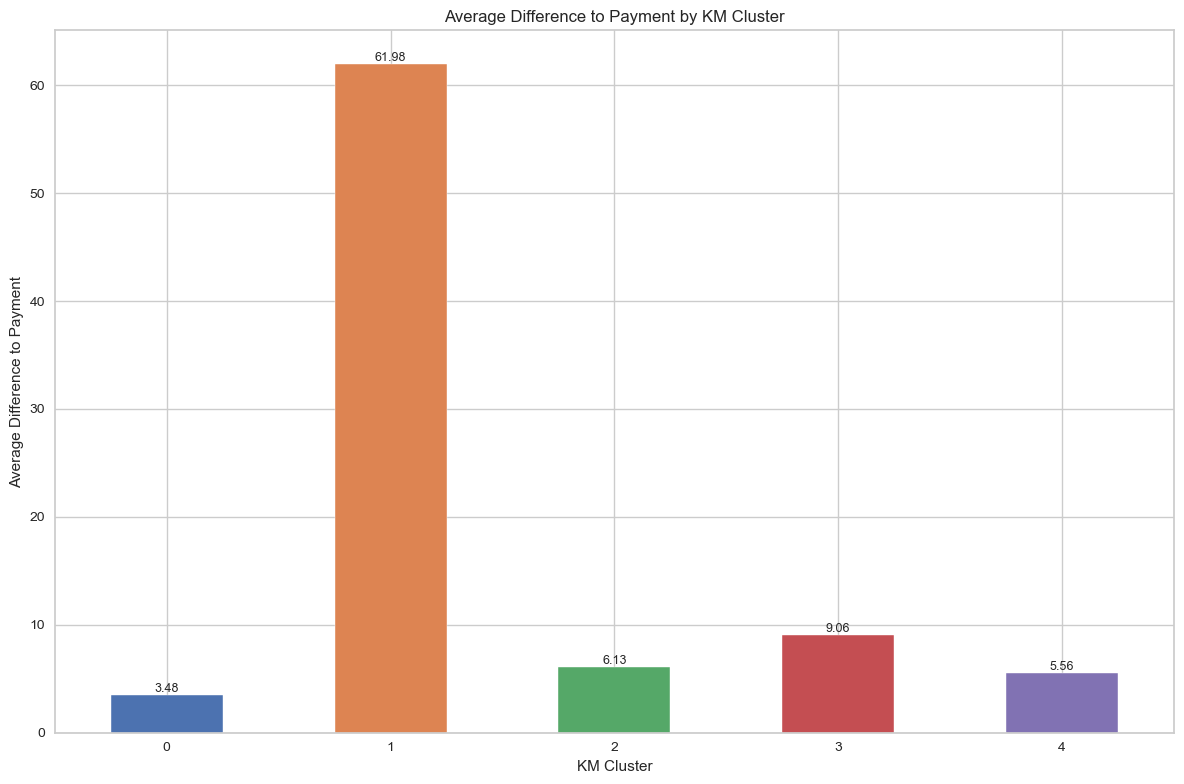

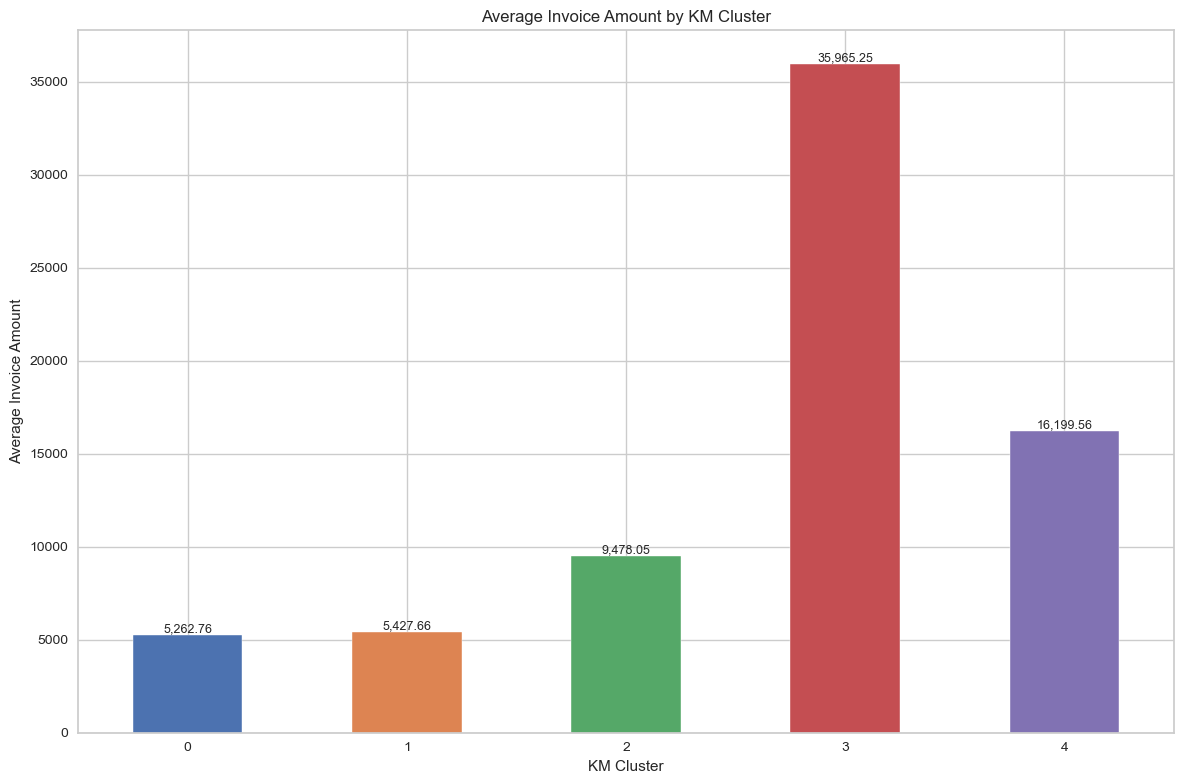

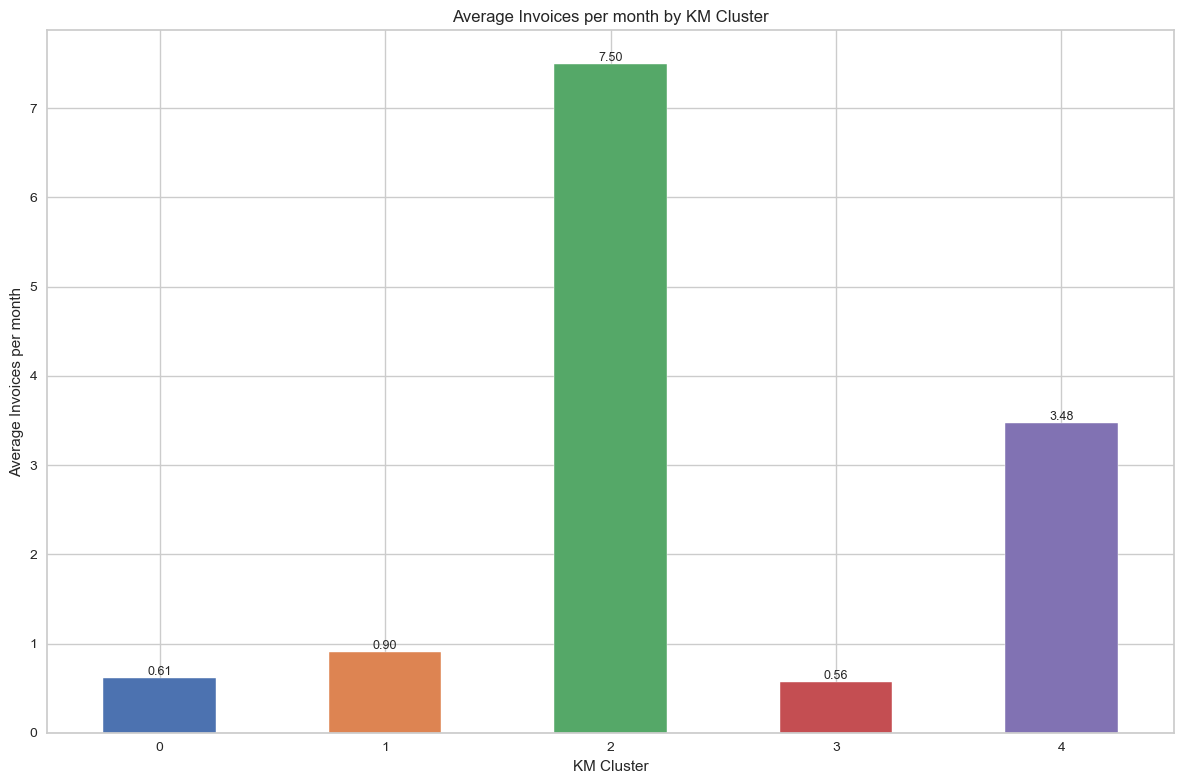

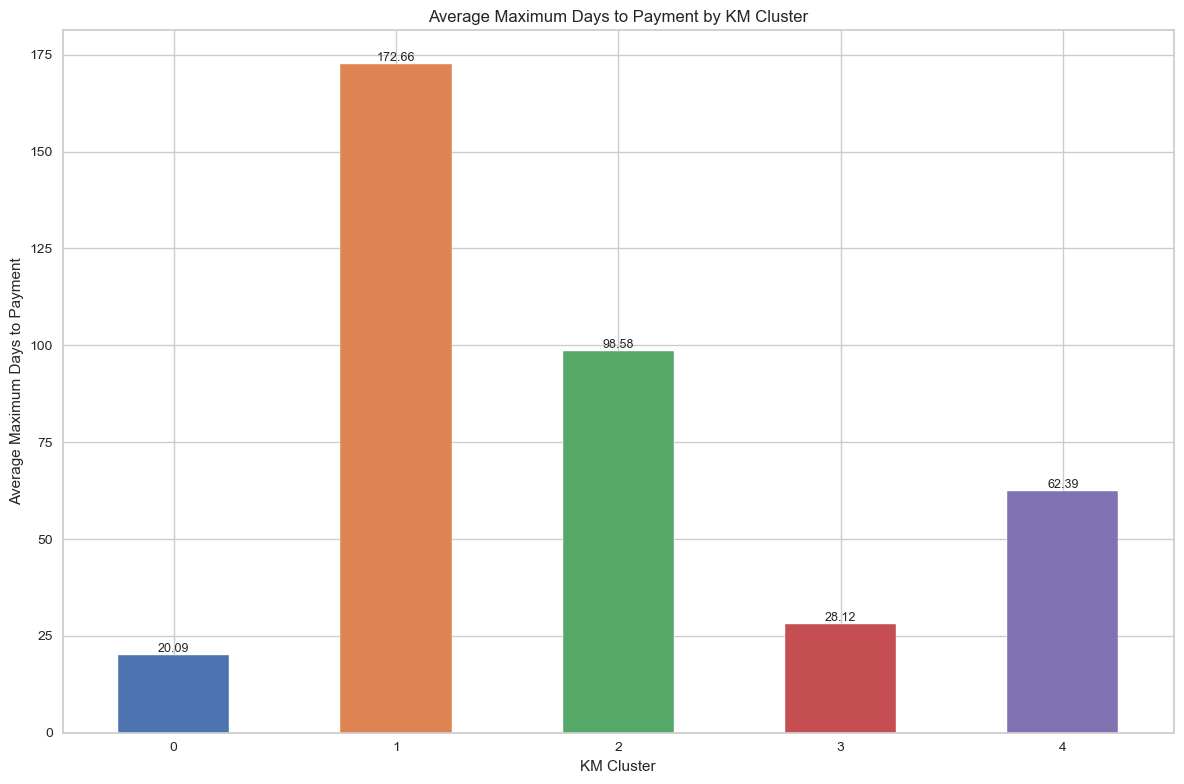

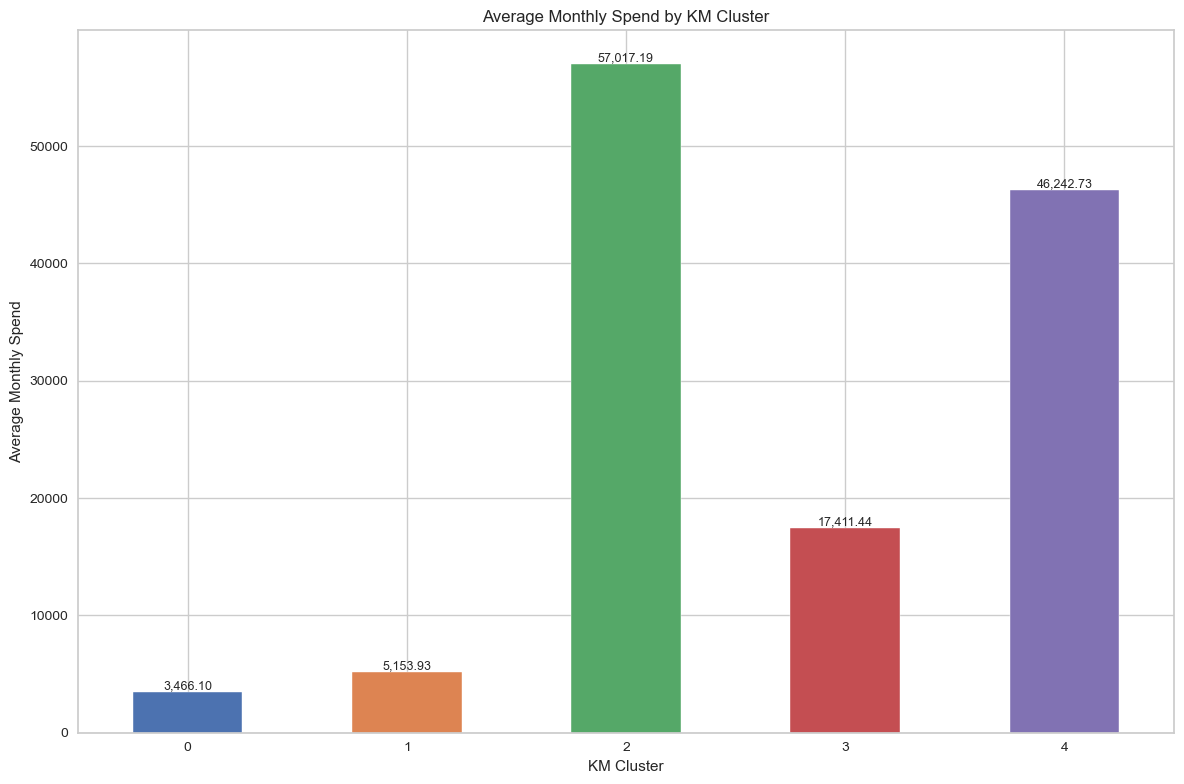

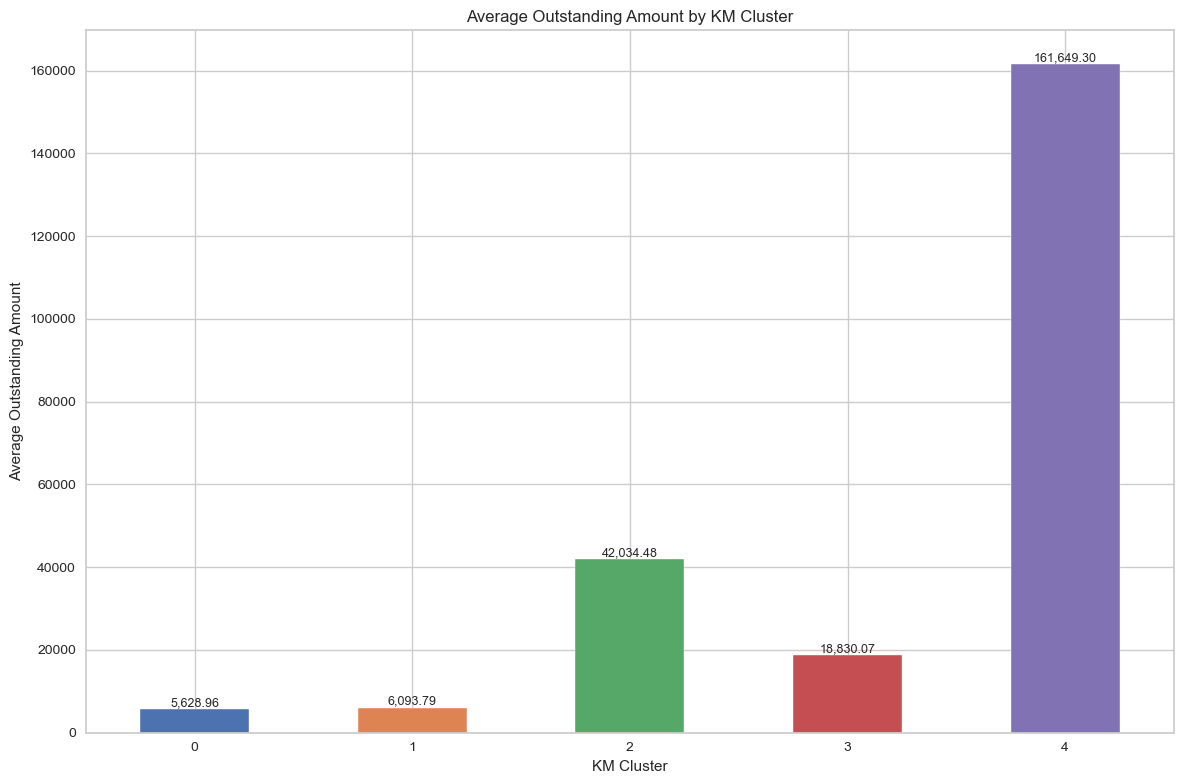

In [223]:
variables = km_summary.columns.levels[0]

palette = sns.color_palette("deep", n_colors=5)
cluster_colors = {i: palette[i] for i in range(5)}

for var in variables:
    mean_values = km_summary[var]['mean']
    colors = [cluster_colors[cluster] for cluster in mean_values.index]
    ax = mean_values.plot(kind='bar', color=colors, figsize=(12, 8))
    for i, val in enumerate(mean_values):
        ax.text(i, val, f'{val:,.2f}', ha='center', va='bottom', fontsize=9)
    plt.title(f'{var} by KM Cluster')
    plt.xlabel('KM Cluster')
    plt.ylabel(f'{var}')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [78]:
# outputdf.to_excel(pathout +'/hca_summary.xlsx', index = False)
# hca_summary

In [79]:
# outputdf.to_excel(pathout +'/dbscan_summary.xlsx', index = False)
# dbscan_summary

### Timer

In [81]:
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Total execution time: 62.25 seconds
